# Phase 1 — Modélisation du prix au m² à Lille (2022) pour les logements de 4 pièces

Dans cette première phase, vous allez construire un **modèle de prédiction du prix au m²** à partir de données issues des **ventes immobilières à Lille**, en vous concentrant sur les **logements de 4 pièces** vendus en **2022**.

Deux études séparées seront menées :

- L’une sur les **appartements**
- L’autre sur les **maisons**

---

### Objectifs

- Comprendre les relations entre certaines caractéristiques des biens (surface, nombre de lots, etc.) et leur prix au m²
- Comparer les dynamiques de prix entre appartements et maisons
- Mettre en œuvre un pipeline de modélisation supervisée
- Sélectionner les modèles les plus performants par type de bien
- Poser les bases d’un futur service d’estimation différencié par catégorie de logement

### Consignes

1. **Charger les données** depuis le fichier `data/lille_2022.csv`

In [70]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

data_lille = pd.read_csv("../data/lille_2022.csv")

# Afficher les 5 premières lignes
print("Aperçu des 5 premières lignes :")
print(data_lille.head())

# Afficher les informations sur le DataFrame
print("\nInformations sur le DataFrame :")
print(data_lille.info())

# Afficher les dimensions du DataFrame
print("\nDimensions du DataFrame (lignes, colonnes) :")
print(data_lille.shape)

Aperçu des 5 premières lignes :
   Identifiant de document  Reference document  1 Articles CGI  \
0                      NaN                 NaN             NaN   
1                      NaN                 NaN             NaN   
2                      NaN                 NaN             NaN   
3                      NaN                 NaN             NaN   
4                      NaN                 NaN             NaN   

   2 Articles CGI  3 Articles CGI  4 Articles CGI  5 Articles CGI  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   No disposition Date mutation Nature mutation  ...  Nombre de lots  \
0               1    03/01/2022           Vente  ...               0   
1           


2. **Filtrer les biens de 4 pièces uniquement** : `Nombre pieces principales == 4`

Valeurs uniques du nombre de pièces :
[ 5.  3.  0.  2.  1.  4.  7.  6.  8. 10. 14.  9. 12. 11. 13.]

Nombre de biens par nombre de pièces :
Nombre pieces principales
0.0     5596
1.0     1471
2.0     1635
3.0     1273
4.0      789
5.0      379
6.0      139
7.0       42
8.0       11
9.0        9
10.0       4
11.0       2
12.0       1
13.0       1
14.0       2
Name: count, dtype: int64

Nombre de biens de 4 pièces : 789

Aperçu des biens de 4 pièces :
    Identifiant de document  Reference document  1 Articles CGI  \
18                      NaN                 NaN             NaN   
23                      NaN                 NaN             NaN   
26                      NaN                 NaN             NaN   
58                      NaN                 NaN             NaN   
62                      NaN                 NaN             NaN   

    2 Articles CGI  3 Articles CGI  4 Articles CGI  5 Articles CGI  \
18             NaN             NaN             NaN             NaN   
23 

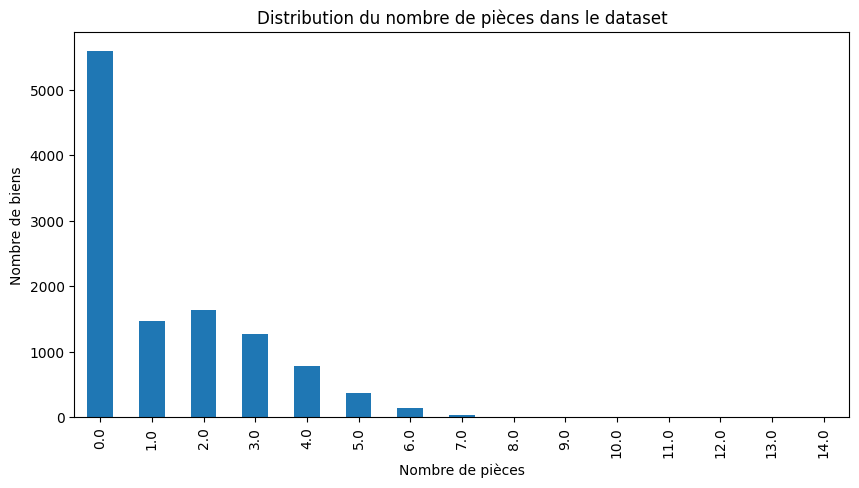

In [71]:
print("Valeurs uniques du nombre de pièces :")
print(data_lille["Nombre pieces principales"].unique())
print("\nNombre de biens par nombre de pièces :")
print(data_lille["Nombre pieces principales"].value_counts().sort_index())

data_4pieces = data_lille[data_lille["Nombre pieces principales"] == 4]

# Vérifier le résultat
print("\nNombre de biens de 4 pièces :", len(data_4pieces))
print("\nAperçu des biens de 4 pièces :")
print(data_4pieces.head())

# Visualisation de la distribution des pièces
plt.figure(figsize=(10, 5))
data_lille["Nombre pieces principales"].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution du nombre de pièces dans le dataset')
plt.xlabel('Nombre de pièces')
plt.ylabel('Nombre de biens')
plt.show()


3. **Créer deux jeux de données distincts** :

    - Un jeu avec uniquement les **appartements**
    - Un jeu avec uniquement les **maisons**


Types de biens disponibles :
['Maison' 'Appartement']

Nombre de appartements de 4 pièces : 435

Aperçu des appartements de 4 pièces :
     Identifiant de document  Reference document  1 Articles CGI  \
23                       NaN                 NaN             NaN   
26                       NaN                 NaN             NaN   
58                       NaN                 NaN             NaN   
62                       NaN                 NaN             NaN   
113                      NaN                 NaN             NaN   

     2 Articles CGI  3 Articles CGI  4 Articles CGI  5 Articles CGI  \
23              NaN             NaN             NaN             NaN   
26              NaN             NaN             NaN             NaN   
58              NaN             NaN             NaN             NaN   
62              NaN             NaN             NaN             NaN   
113             NaN             NaN             NaN             NaN   

     No disposition Date muta

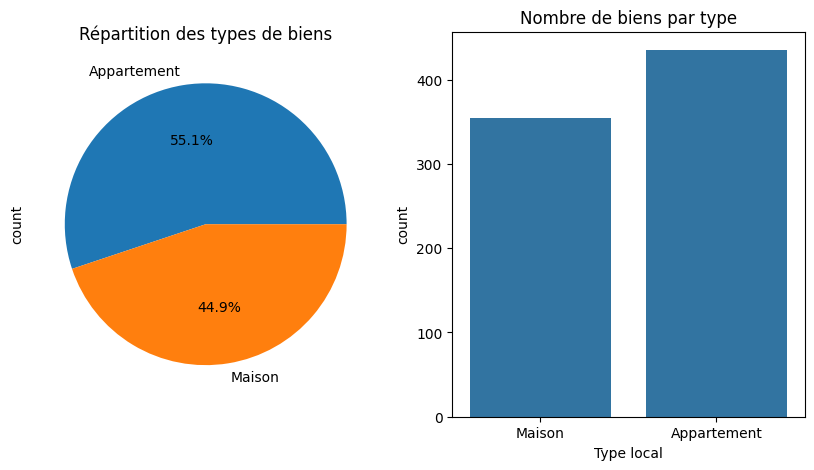

In [72]:
print("Types de biens disponibles :")
print(data_4pieces["Type local"].unique())

data_appartements_4pieces = data_4pieces[data_4pieces["Type local"] == "Appartement"]

data_maisons_4pieces = data_4pieces[data_4pieces["Type local"] == "Maison"]

# Vérifier le résultat
print("\nNombre de appartements de 4 pièces :", len(data_appartements_4pieces))
print("\nAperçu des appartements de 4 pièces :")
print(data_appartements_4pieces.head())
print("\nNombre de maisons de 4 pièces :", len(data_maisons_4pieces))
print("\nAperçu des maisons de 4 pièces :")
print(data_maisons_4pieces.head())

# Visualisation de la répartition
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
data_4pieces['Type local'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Répartition des types de biens')

plt.subplot(1, 2, 2)
sns.countplot(data=data_4pieces, x='Type local')
plt.title('Nombre de biens par type')
plt.show()


4. Pour chaque jeu, ne conservez que les colonnes suivantes :
    - `Surface reelle bati`
    - `Nombre pieces principales`
    - `Type local`
    - `Surface terrain` (si disponible)
    - `Nombre de lots`
    - `Valeur fonciere` (pour calculer le `prix_m2`)

In [73]:
colonnes_à_garder = [
    'Surface reelle bati',
    'Nombre pieces principales',
    'Type local',
    'Surface terrain',
    'Nombre de lots',
    'Valeur fonciere'
]

df_appartements_4pieces = data_appartements_4pieces[colonnes_à_garder].copy()
print(df_appartements_4pieces.columns)
print(df_appartements_4pieces.info())

df_maisons_4pieces = data_maisons_4pieces[colonnes_à_garder].copy()
print(df_maisons_4pieces.columns)
print(df_maisons_4pieces.info())



Index(['Surface reelle bati', 'Nombre pieces principales', 'Type local',
       'Surface terrain', 'Nombre de lots', 'Valeur fonciere'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, 23 to 11351
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Surface reelle bati        435 non-null    float64
 1   Nombre pieces principales  435 non-null    float64
 2   Type local                 435 non-null    object 
 3   Surface terrain            49 non-null     float64
 4   Nombre de lots             435 non-null    int64  
 5   Valeur fonciere            435 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 23.8+ KB
None
Index(['Surface reelle bati', 'Nombre pieces principales', 'Type local',
       'Surface terrain', 'Nombre de lots', 'Valeur fonciere'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 354 entries, 18 to 

5. **Créer la variable cible** :
    
    ```python
    prix_m2 = Valeur fonciere / Surface reelle bati
    ```


Statistiques prix/m² appartements :
count      435.000000
mean      4989.066032
std       7087.899307
min          0.011494
25%       2617.078231
50%       3285.714286
75%       4310.382231
max      52065.934066
Name: prix_m2, dtype: float64

Statistiques prix/m² maisons :
count     354.000000
mean     3003.594635
std      1116.900260
min       144.144144
25%      2291.390977
50%      2847.948718
75%      3481.995492
max      9192.073171
Name: prix_m2, dtype: float64


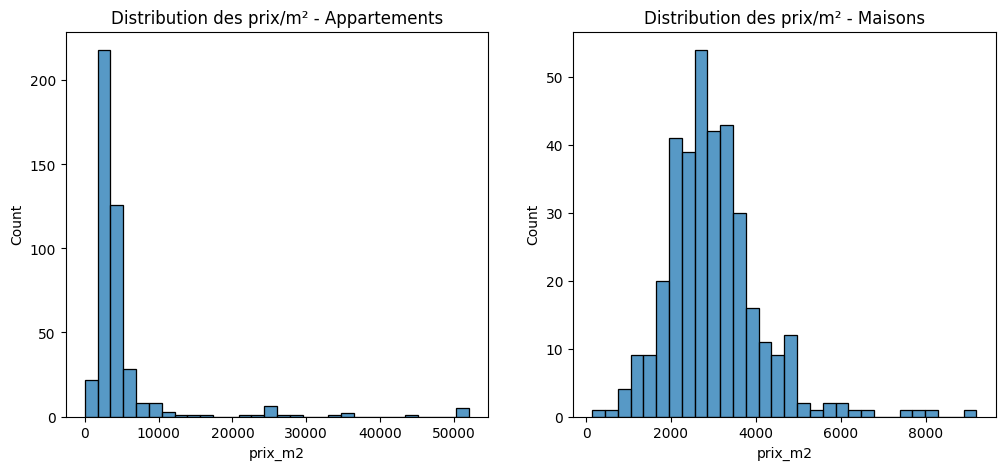

In [74]:
# Ajouter la colonne prix_m2
df_appartements_4pieces['prix_m2'] = df_appartements_4pieces['Valeur fonciere'] / df_appartements_4pieces['Surface reelle bati']
df_maisons_4pieces['prix_m2'] = df_maisons_4pieces['Valeur fonciere'] / df_maisons_4pieces['Surface reelle bati']

# Vérifier les résultats
print("Statistiques prix/m² appartements :")
print(df_appartements_4pieces['prix_m2'].describe())
print("\nStatistiques prix/m² maisons :")
print(df_maisons_4pieces['prix_m2'].describe())

# Comparaison des distributions de prix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_appartements_4pieces, x='prix_m2', bins=30)
plt.title('Distribution des prix/m² - Appartements')

plt.subplot(1, 2, 2)
sns.histplot(data=df_maisons_4pieces, x='prix_m2', bins=30)
plt.title('Distribution des prix/m² - Maisons')
plt.show()

6. **Nettoyer les données** :
    - Supprimer les lignes avec valeurs manquantes sur les colonnes utilisées
    - Identifier et retirer les valeurs aberrantes (prix au m² trop faible ou trop élevé)

In [75]:
print("Valeurs manquantes - Appartements : ")
print(df_appartements_4pieces.isnull().sum())

print("Valeurs manquantes - Maisons : ")
print(df_maisons_4pieces.isnull().sum())

df_appartements_4pieces['Surface terrain'] = df_appartements_4pieces['Surface terrain'].fillna(0)

df_maisons_4pieces['Surface terrain'] = df_maisons_4pieces['Surface terrain'].fillna(df_maisons_4pieces['Surface terrain'].median())

# Vérifier que les remplacements ont fonctionné
print("\nAprès remplacement - Valeurs manquantes Appartements :")
print(df_appartements_4pieces.isnull().sum())
print("\nAprès remplacement - Valeurs manquantes Maisons :")
print(df_maisons_4pieces.isnull().sum())

Valeurs manquantes - Appartements : 
Surface reelle bati            0
Nombre pieces principales      0
Type local                     0
Surface terrain              386
Nombre de lots                 0
Valeur fonciere                0
prix_m2                        0
dtype: int64
Valeurs manquantes - Maisons : 
Surface reelle bati           0
Nombre pieces principales     0
Type local                    0
Surface terrain              14
Nombre de lots                0
Valeur fonciere               0
prix_m2                       0
dtype: int64

Après remplacement - Valeurs manquantes Appartements :
Surface reelle bati          0
Nombre pieces principales    0
Type local                   0
Surface terrain              0
Nombre de lots               0
Valeur fonciere              0
prix_m2                      0
dtype: int64

Après remplacement - Valeurs manquantes Maisons :
Surface reelle bati          0
Nombre pieces principales    0
Type local                   0
Surface terrain     

Nouvelles statistiques après filtrage des valeurs aberrantes:

Appartements:
count     358.000000
mean     3158.870448
std       877.706535
min       416.666667
25%      2554.919499
50%      3106.137387
75%      3782.294097
max      5147.727273
Name: prix_m2, dtype: float64

Maisons:
count     307.000000
mean     2714.995157
std       688.648728
min       825.123273
25%      2211.310969
50%      2762.637363
75%      3225.694444
max      4061.046512
Name: prix_m2, dtype: float64


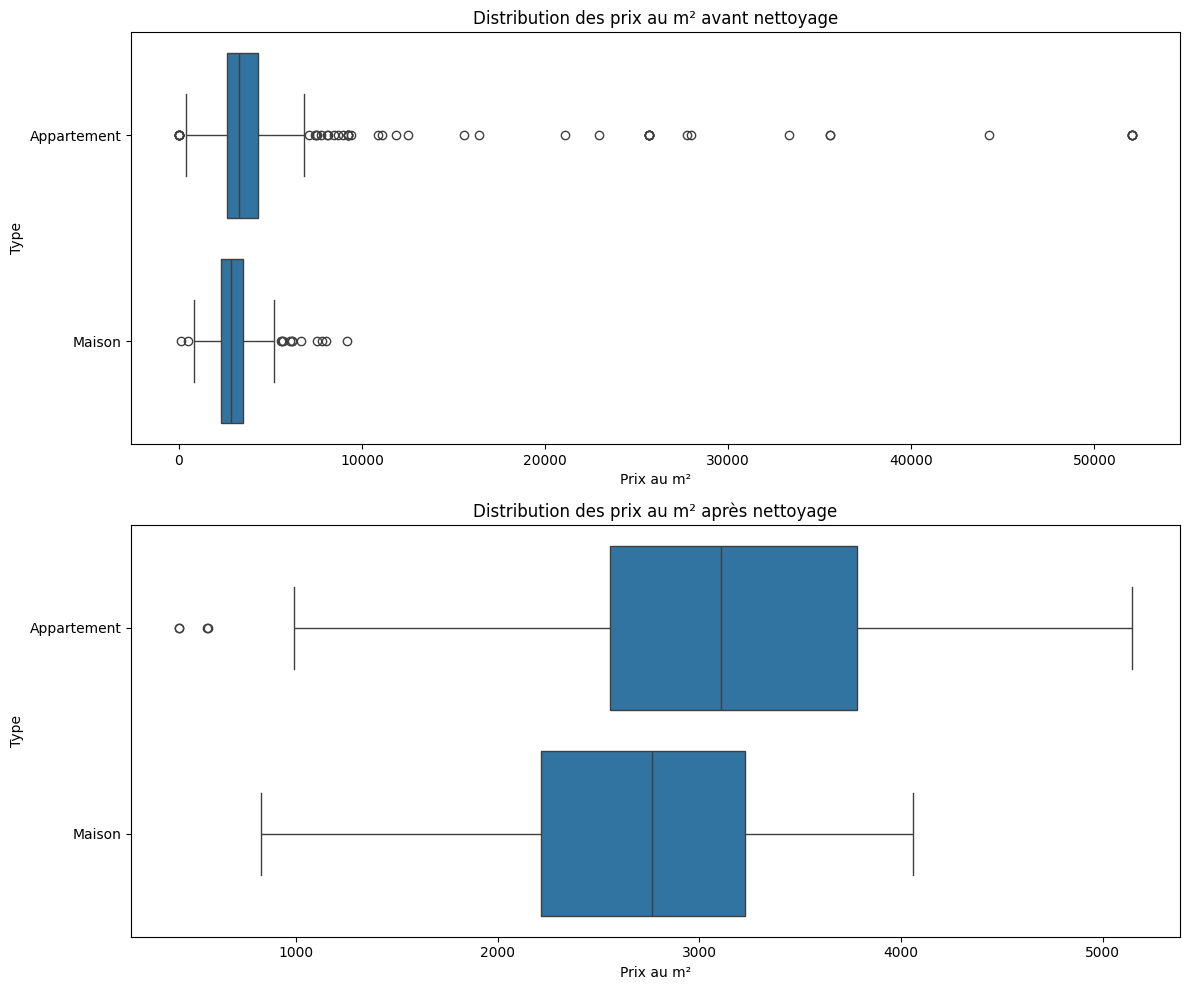

In [76]:
Q1_appartements = df_appartements_4pieces['prix_m2'].quantile(0.25)
Q3_appartements = df_appartements_4pieces['prix_m2'].quantile(0.75)
IQR_appartements = Q3_appartements - Q1_appartements
seuil_bas_appartements = Q1_appartements - 1.5 * IQR_appartements
seuil_haut_appartements = Q1_appartements + 1.5 * IQR_appartements

Q1_maisons = df_maisons_4pieces['prix_m2'].quantile(0.25)
Q3_maisons = df_maisons_4pieces['prix_m2'].quantile(0.75)
IQR_maisons = Q3_maisons - Q1_maisons
seuil_bas_maisons = Q1_maisons - 1.5 * IQR_maisons
seuil_haut_maisons = Q1_maisons + 1.5 * IQR_maisons

df_appartements_4pieces = df_appartements_4pieces[
    (df_appartements_4pieces['prix_m2'] >= seuil_bas_appartements) &
    (df_appartements_4pieces['prix_m2'] <= seuil_haut_appartements)
]

df_maisons_4pieces = df_maisons_4pieces[
    (df_maisons_4pieces['prix_m2'] >= seuil_bas_maisons) &
    (df_maisons_4pieces['prix_m2'] <= seuil_haut_maisons)
]

# Vérifier les nouvelles statistiques
print("Nouvelles statistiques après filtrage des valeurs aberrantes:")
print("\nAppartements:")
print(df_appartements_4pieces['prix_m2'].describe())
print("\nMaisons:")
print(df_maisons_4pieces['prix_m2'].describe())

# Avant/Après nettoyage
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Avant nettoyage
# Create combined DataFrame for visualization before cleaning
df_prix_combined = pd.DataFrame({
    'Prix au m²': pd.concat([data_appartements_4pieces['prix_m2'], 
                           data_maisons_4pieces['prix_m2']]),
    'Type': ['Appartement'] * len(data_appartements_4pieces) + 
            ['Maison'] * len(data_maisons_4pieces)
})

sns.boxplot(data=df_prix_combined, y='Type', x='Prix au m²', orient='h', ax=axes[0])
axes[0].set_title('Distribution des prix au m² avant nettoyage')

# Après nettoyage (à placer après le filtrage IQR)
df_prix_clean = pd.DataFrame({
    'Prix au m²': pd.concat([df_appartements_4pieces['prix_m2'], 
                           df_maisons_4pieces['prix_m2']]),
    'Type': ['Appartement'] * len(df_appartements_4pieces) + 
            ['Maison'] * len(df_maisons_4pieces)
})
sns.boxplot(data=df_prix_clean, y='Type', x='Prix au m²', orient='h', ax=axes[1])
axes[1].set_title('Distribution des prix au m² après nettoyage')
plt.tight_layout()
plt.show()


**7. Préparer les données pour l'entraînement**

- Variables explicatives : `X`
- Variable cible : `y = prix_m2`
- Division en jeu d'entraînement (80%) et test (20%) avec `train_test_split`

Dimensions des jeux de données d'appartements :
X_train : (286, 3)
X_test : (72, 3)

Dimensions des jeux de données de maisons :
X_train : (245, 3)
X_test : (62, 3)


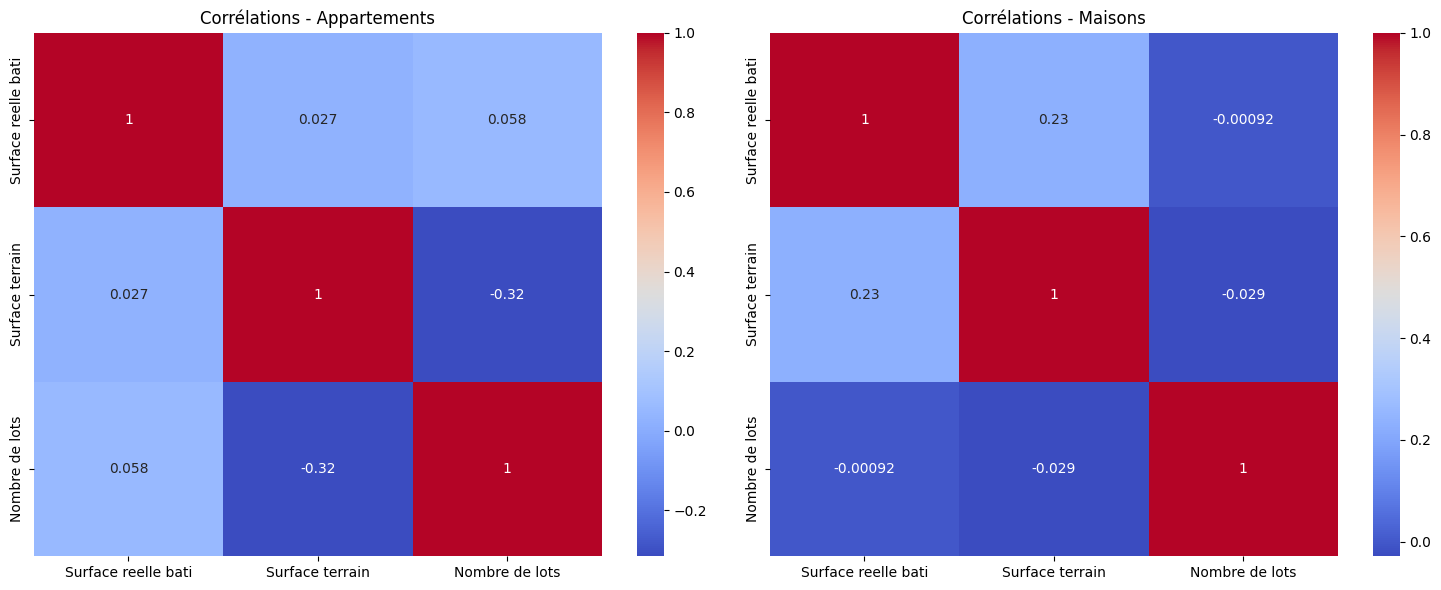

In [77]:
# Pour les appartements
colonnes_expliquatives = [
    'Surface reelle bati', 
    'Surface terrain', 
    'Nombre de lots'
]

X_appartements = df_appartements_4pieces[colonnes_expliquatives]
y_appartements = df_appartements_4pieces['prix_m2']

X_train_appartements, X_test_appartements, y_train_appartements, y_test_appartements = train_test_split(X_appartements, y_appartements, test_size=0.2, random_state=42)

# Pour les maisons
X_maisons = df_maisons_4pieces[colonnes_expliquatives]
y_maisons = df_maisons_4pieces['prix_m2']

X_train_maisons, X_test_maisons, y_train_maisons, y_test_maisons = train_test_split(X_maisons, y_maisons, test_size=0.2, random_state=42)

# Vérifier les dimensions
print("Dimensions des jeux de données d'appartements :")
print(f"X_train : {X_train_appartements.shape}")
print(f"X_test : {X_test_appartements.shape}")
print("\nDimensions des jeux de données de maisons :")
print(f"X_train : {X_train_maisons.shape}")
print(f"X_test : {X_test_maisons.shape}")

# Visualisation des corrélations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Matrice de corrélation - Appartements
sns.heatmap(X_train_appartements.corr(), annot=True, cmap='coolwarm', ax=ax1)
ax1.set_title('Corrélations - Appartements')

# Matrice de corrélation - Maisons
sns.heatmap(X_train_maisons.corr(), annot=True, cmap='coolwarm', ax=ax2)
ax2.set_title('Corrélations - Maisons')

plt.tight_layout()
plt.show()


**8. Entraîner les modèles de base avec `scikit-learn`**

- `LinearRegression`
- `DecisionTreeRegressor`
- `RandomForestRegressor`

Coeffectients du modèle : [[0.16480089 0.05855477 0.11000993]]
MSE : 0.9718080739085843
RMSE : 0.9858032632876522
R² : -0.006822175367785066


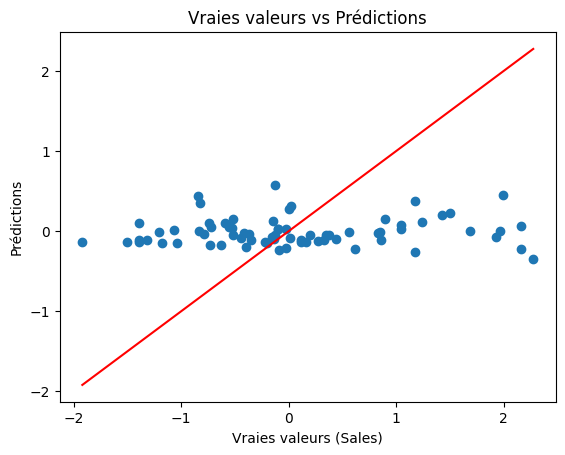

In [78]:
# LinearRegression pour les Appartements

# Standardisation Appartements
scaler_X_appartements = StandardScaler()
X_train_appartements_scaled = scaler_X_appartements.fit_transform(X_train_appartements)
X_test_appartements_scaled = scaler_X_appartements.transform(X_test_appartements)

scaler_y_appartements = StandardScaler()
y_train_appartements_scaled = scaler_y_appartements.fit_transform(y_train_appartements.values.reshape(-1,1))
y_test_appartements_scaled = scaler_y_appartements.transform(y_test_appartements.values.reshape(-1, 1))

# Entraînement du modèle Appartements
model_appartements = LinearRegression()
model_appartements.fit(X_train_appartements_scaled, y_train_appartements_scaled)

# Evaluation du modèle Appartements
y_pred_appartements_scaled = model_appartements.predict(X_test_appartements_scaled)

# Coefficients
print(f"Coeffectients du modèle : {model_appartements.coef_}")

# Metrics
mse = mean_squared_error(y_test_appartements_scaled, y_pred_appartements_scaled)
print("MSE :", mse)
print("RMSE :", np.sqrt(mse))
print("R² :", r2_score(y_test_appartements_scaled, y_pred_appartements_scaled))

# Visualisation
plt.scatter(y_test_appartements_scaled, y_pred_appartements_scaled)
plt.plot([y_test_appartements_scaled.min(), y_test_appartements_scaled.max()], [y_test_appartements_scaled.min(), y_test_appartements_scaled.max()], color="r")
plt.xlabel("Vraies valeurs (Sales)")
plt.ylabel("Prédictions")
plt.title("Vraies valeurs vs Prédictions")
plt.show()

Coefficients du modèle maisons : [[-0.14928223  0.08599594 -0.14871899]]
MSE : 1.487447798379359
RMSE : 1.21960969099928
R² : -0.02624499461868668


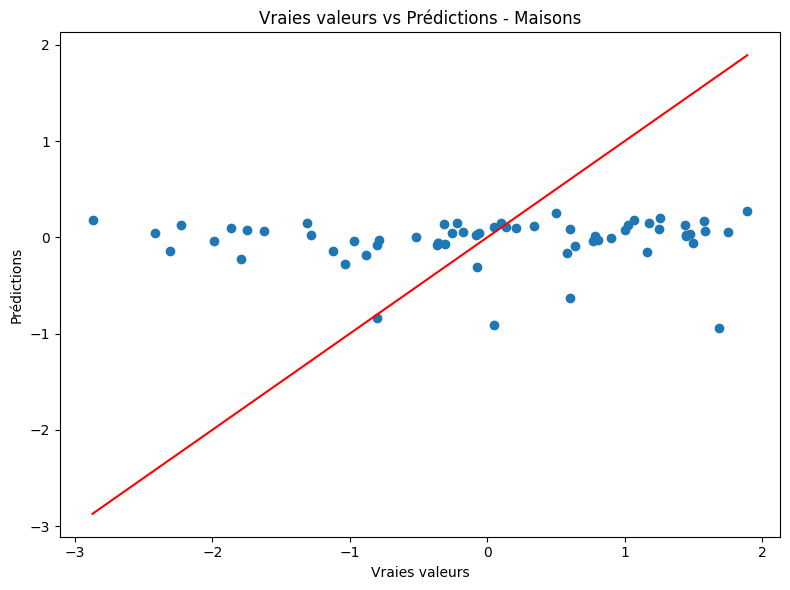

In [79]:
# LinearRegression pour les Maisons

# Standardisation Maisons
scaler_X_maisons = StandardScaler()
X_train_maisons_scaled = scaler_X_maisons.fit_transform(X_train_maisons)
X_test_maisons_scaled = scaler_X_maisons.transform(X_test_maisons)

scaler_y_maisons = StandardScaler()
y_train_maisons_scaled = scaler_y_maisons.fit_transform(y_train_maisons.values.reshape(-1, 1))
y_test_maisons_scaled = scaler_y_maisons.transform(y_test_maisons.values.reshape(-1, 1))

# Entraînement du modèle Maisons
model_maisons = LinearRegression()
model_maisons.fit(X_train_maisons_scaled, y_train_maisons_scaled)

# Evaluation du modèle Maisons
y_pred_maisons_scaled = model_maisons.predict(X_test_maisons_scaled)

# Coefficients
print(f"Coefficients du modèle maisons : {model_maisons.coef_}")

# Metrics
mse_maisons = mean_squared_error(y_test_maisons_scaled, y_pred_maisons_scaled)
print("MSE :", mse_maisons)
print("RMSE :", np.sqrt(mse_maisons))
print("R² :", r2_score(y_test_maisons_scaled, y_pred_maisons_scaled))

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test_maisons_scaled, y_pred_maisons_scaled)
plt.plot([y_test_maisons_scaled.min(), y_test_maisons_scaled.max()], 
         [y_test_maisons_scaled.min(), y_test_maisons_scaled.max()], 
         color="r")
plt.xlabel("Vraies valeurs")
plt.ylabel("Prédictions")
plt.title("Vraies valeurs vs Prédictions - Maisons")
plt.tight_layout()
plt.show()

Résultats DecisionTree pour les appartements:
MSE: 1.3130
RMSE: 1.1459
R²: -0.3603


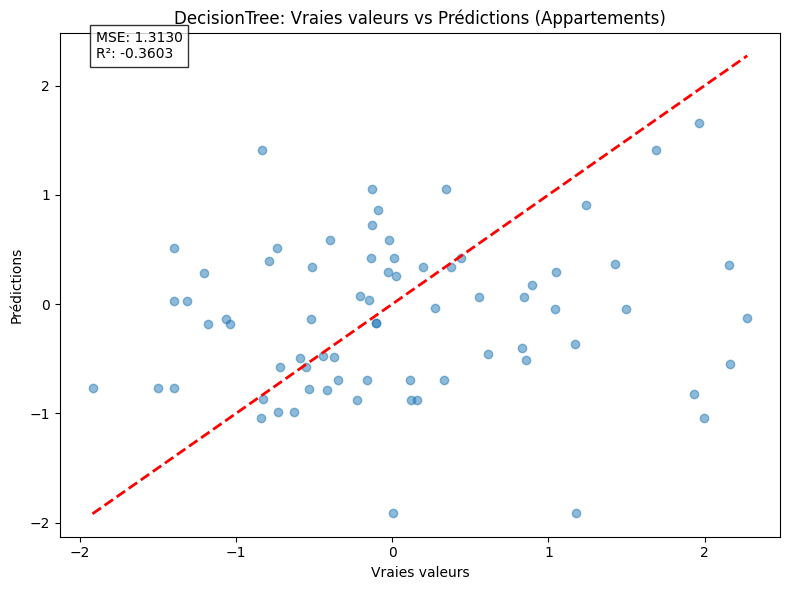

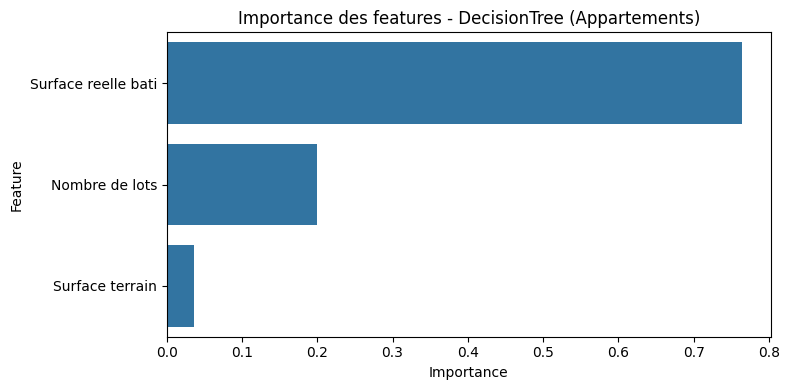

In [80]:
# DecisionTreeRegressor pour les Appartements

# Modèle DecisionTree pour les appartements
dt_model_appartements = DecisionTreeRegressor(random_state=42)
dt_model_appartements.fit(X_train_appartements_scaled, y_train_appartements_scaled)

# Prédictions
y_pred_dt_appartements = dt_model_appartements.predict(X_test_appartements_scaled)

# Métriques d'évaluation
mse_dt = mean_squared_error(y_test_appartements_scaled, y_pred_dt_appartements)
r2_dt = r2_score(y_test_appartements_scaled, y_pred_dt_appartements)

print("Résultats DecisionTree pour les appartements:")
print(f"MSE: {mse_dt:.4f}")
print(f"RMSE: {np.sqrt(mse_dt):.4f}")
print(f"R²: {r2_dt:.4f}")

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test_appartements_scaled, y_pred_dt_appartements, alpha=0.5)
plt.plot([y_test_appartements_scaled.min(), y_test_appartements_scaled.max()], 
         [y_test_appartements_scaled.min(), y_test_appartements_scaled.max()], 
         'r--', lw=2)
plt.xlabel('Vraies valeurs')
plt.ylabel('Prédictions')
plt.title('DecisionTree: Vraies valeurs vs Prédictions (Appartements)')

# Ajout de la légende des métriques
plt.text(0.05, 0.95, f'MSE: {mse_dt:.4f}\nR²: {r2_dt:.4f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Importance des features
importance = pd.DataFrame({
    'Feature': colonnes_expliquatives,
    'Importance': dt_model_appartements.feature_importances_
})
importance = importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('Importance des features - DecisionTree (Appartements)')
plt.tight_layout()
plt.show()

Résultats DecisionTree pour les maisons:
MSE: 2.1814
RMSE: 1.4770
R²: -0.5050


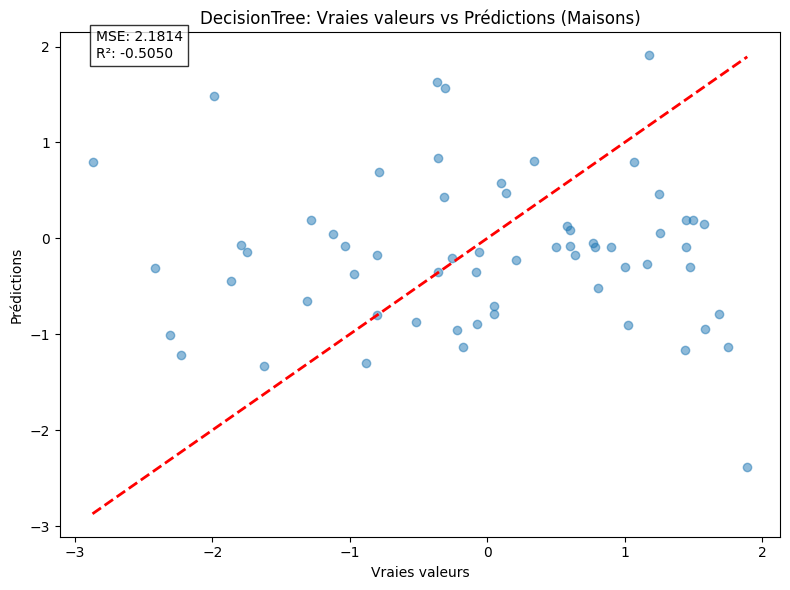

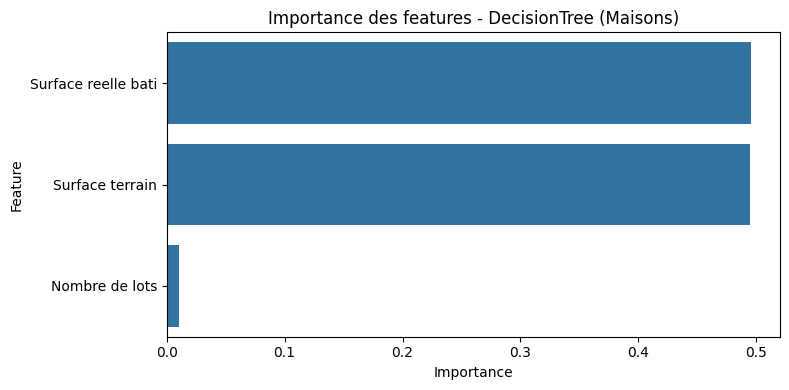

In [81]:
# DecisionTreeRegressor pour les Maisons
dt_model_maisons = DecisionTreeRegressor(random_state=42)
dt_model_maisons.fit(X_train_maisons_scaled, y_train_maisons_scaled)

# Prédictions
y_pred_dt_maisons = dt_model_maisons.predict(X_test_maisons_scaled)

# Métriques d'évaluation
mse_dt_maisons = mean_squared_error(y_test_maisons_scaled, y_pred_dt_maisons)
r2_dt_maisons = r2_score(y_test_maisons_scaled, y_pred_dt_maisons)

print("Résultats DecisionTree pour les maisons:")
print(f"MSE: {mse_dt_maisons:.4f}")
print(f"RMSE: {np.sqrt(mse_dt_maisons):.4f}")
print(f"R²: {r2_dt_maisons:.4f}")

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test_maisons_scaled, y_pred_dt_maisons, alpha=0.5)
plt.plot([y_test_maisons_scaled.min(), y_test_maisons_scaled.max()], 
         [y_test_maisons_scaled.min(), y_test_maisons_scaled.max()], 
         'r--', lw=2)
plt.xlabel('Vraies valeurs')
plt.ylabel('Prédictions')
plt.title('DecisionTree: Vraies valeurs vs Prédictions (Maisons)')

# Ajout de la légende des métriques
plt.text(0.05, 0.95, f'MSE: {mse_dt_maisons:.4f}\nR²: {r2_dt_maisons:.4f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Importance des features
importance_maisons = pd.DataFrame({
    'Feature': colonnes_expliquatives,
    'Importance': dt_model_maisons.feature_importances_
})
importance_maisons = importance_maisons.sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_maisons)
plt.title('Importance des features - DecisionTree (Maisons)')
plt.tight_layout()
plt.show()

Résultats RandomForest pour les appartements:
MSE: 1.0894
RMSE: 1.0438
R²: -0.1287


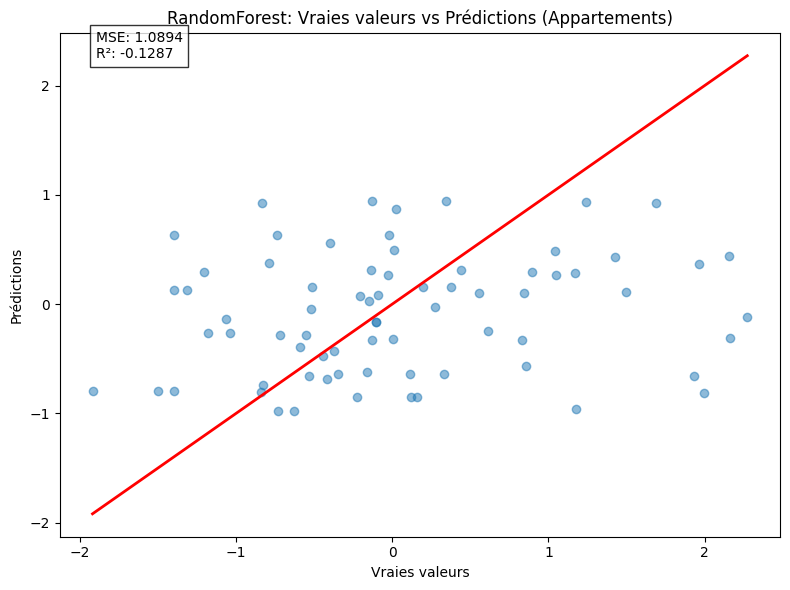

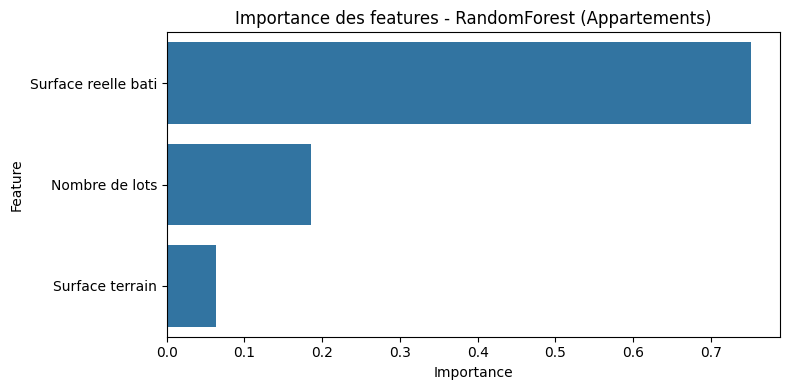

In [82]:
# RandomForestRegressor pour les Appartements

# Modèle RandomForest pour les appartements 
rf_model_appartements = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_appartements.fit(X_train_appartements_scaled, y_train_appartements_scaled.ravel())

# Prédictions
y_pred_rf_appartements = rf_model_appartements.predict(X_test_appartements_scaled)

# Métriques d'évaluation
mse_rf = mean_squared_error(y_test_appartements_scaled, y_pred_rf_appartements)
r2_rf = r2_score(y_test_appartements_scaled, y_pred_rf_appartements)

print("Résultats RandomForest pour les appartements:")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {np.sqrt(mse_rf):.4f}")
print(f"R²: {r2_rf:.4f}")

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test_appartements_scaled, y_pred_rf_appartements, alpha=0.5)
plt.plot([y_test_appartements_scaled.min(), y_test_appartements_scaled.max()], 
         [y_test_appartements_scaled.min(), y_test_appartements_scaled.max()], 
         'r', lw=2)
plt.xlabel('Vraies valeurs')
plt.ylabel('Prédictions')
plt.title('RandomForest: Vraies valeurs vs Prédictions (Appartements)')

# Ajout de la légende des métriques
plt.text(0.05, 0.95, f'MSE: {mse_rf:.4f}\nR²: {r2_rf:.4f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Importance des features
importance_rf = pd.DataFrame({
    'Feature': colonnes_expliquatives,
    'Importance': rf_model_appartements.feature_importances_
})
importance_rf = importance_rf.sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_rf)
plt.title('Importance des features - RandomForest (Appartements)')
plt.tight_layout()
plt.show()

Résultats RandomForest pour les maisons:
MSE: 1.6502
RMSE: 1.2846
R²: -0.1385


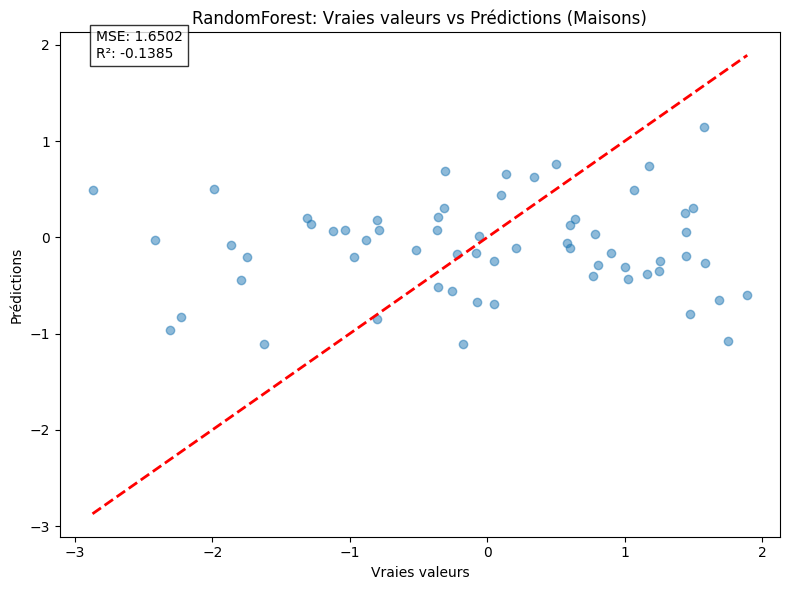

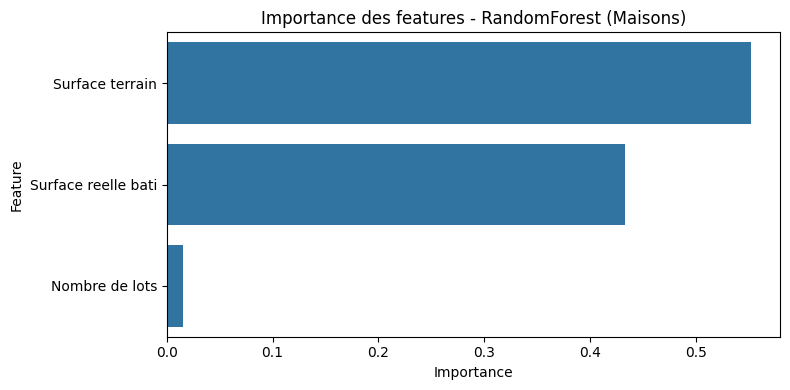

In [83]:
# RandomForestRegressor pour les Maisons
rf_model_maisons = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_maisons.fit(X_train_maisons_scaled, y_train_maisons_scaled.ravel())

# Prédictions
y_pred_rf_maisons = rf_model_maisons.predict(X_test_maisons_scaled)

# Métriques d'évaluation
mse_rf_maisons = mean_squared_error(y_test_maisons_scaled, y_pred_rf_maisons)
r2_rf_maisons = r2_score(y_test_maisons_scaled, y_pred_rf_maisons)

print("Résultats RandomForest pour les maisons:")
print(f"MSE: {mse_rf_maisons:.4f}")
print(f"RMSE: {np.sqrt(mse_rf_maisons):.4f}")
print(f"R²: {r2_rf_maisons:.4f}")

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test_maisons_scaled, y_pred_rf_maisons, alpha=0.5)
plt.plot([y_test_maisons_scaled.min(), y_test_maisons_scaled.max()], 
         [y_test_maisons_scaled.min(), y_test_maisons_scaled.max()], 
         'r--', lw=2)
plt.xlabel('Vraies valeurs')
plt.ylabel('Prédictions')
plt.title('RandomForest: Vraies valeurs vs Prédictions (Maisons)')

# Ajout de la légende des métriques
plt.text(0.05, 0.95, f'MSE: {mse_rf_maisons:.4f}\nR²: {r2_rf_maisons:.4f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Importance des features
importance_rf_maisons = pd.DataFrame({
    'Feature': colonnes_expliquatives,
    'Importance': rf_model_maisons.feature_importances_
})
importance_rf_maisons = importance_rf_maisons.sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_rf_maisons)
plt.title('Importance des features - RandomForest (Maisons)')
plt.tight_layout()
plt.show()


**9. Optimiser les modèles d’arbres avec `GridSearchCV`**

- Appliquer une recherche d’hyperparamètres sur les arbres pour améliorer les résultats

In [ ]:
# Paramètres à tester pour DecisionTree
dt_param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Paramètres à tester pour RandomForest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Optimisation pour les appartements
print("Optimisation des modèles pour les appartements...")

# DecisionTree - Appartements
dt_grid_appartements = GridSearchCV(DecisionTreeRegressor(random_state=42), 
                                  dt_param_grid, 
                                  cv=5, 
                                  scoring='neg_mean_squared_error',
                                  n_jobs=-1)


dt_grid_appartements.fit(X_train_appartements_scaled, y_train_appartements_scaled.ravel())
print("\nMeilleurs paramètres DecisionTree (Appartements):")
print(dt_grid_appartements.best_params_)
print(f"Meilleur score MSE: {-dt_grid_appartements.best_score_:.4f}")

# RandomForest - Appartements
rf_grid_appartements = GridSearchCV(RandomForestRegressor(random_state=42), 
                                  rf_param_grid, 
                                  cv=5, 
                                  scoring='neg_mean_squared_error',
                                  n_jobs=-1)

rf_grid_appartements.fit(X_train_appartements_scaled, y_train_appartements_scaled.ravel())
print("\nMeilleurs paramètres RandomForest (Appartements):")
print(rf_grid_appartements.best_params_)
print(f"Meilleur score MSE: {-rf_grid_appartements.best_score_:.4f}")

# Optimisation pour les maisons
print("\nOptimisation des modèles pour les maisons...")

# DecisionTree - Maisons
dt_grid_maisons = GridSearchCV(DecisionTreeRegressor(random_state=42), 
                             dt_param_grid, 
                             cv=5, 
                             scoring='neg_mean_squared_error',
                             n_jobs=-1)

dt_grid_maisons.fit(X_train_maisons_scaled, y_train_maisons_scaled.ravel())
print("\nMeilleurs paramètres DecisionTree (Maisons):")
print(dt_grid_maisons.best_params_)
print(f"Meilleur score MSE: {-dt_grid_maisons.best_score_:.4f}")

# RandomForest - Maisons
rf_grid_maisons = GridSearchCV(RandomForestRegressor(random_state=42), 
                             rf_param_grid, 
                             cv=5, 
                             scoring='neg_mean_squared_error',
                             n_jobs=-1)

rf_grid_maisons.fit(X_train_maisons_scaled, y_train_maisons_scaled.ravel())
print("\nMeilleurs paramètres RandomForest (Maisons):")
print(rf_grid_maisons.best_params_)
print(f"Meilleur score MSE: {-rf_grid_maisons.best_score_:.4f}")

# Évaluation des modèles optimisés sur le jeu de test
y_pred_dt_app_opt = dt_grid_appartements.predict(X_test_appartements_scaled)
y_pred_rf_app_opt = rf_grid_appartements.predict(X_test_appartements_scaled)
y_pred_dt_mai_opt = dt_grid_maisons.predict(X_test_maisons_scaled)
y_pred_rf_mai_opt = rf_grid_maisons.predict(X_test_maisons_scaled)

# Affichage des performances sur le jeu de test
print("\nPerformances sur le jeu de test:")
print("MSE DecisionTree optimisé (Appartements):", 
      mean_squared_error(y_test_appartements_scaled, y_pred_dt_app_opt))
print("MSE RandomForest optimisé (Appartements):", 
      mean_squared_error(y_test_appartements_scaled, y_pred_rf_app_opt))
print("MSE DecisionTree optimisé (Maisons):", 
      mean_squared_error(y_test_maisons_scaled, y_pred_dt_mai_opt))
print("MSE RandomForest optimisé (Maisons):", 
      mean_squared_error(y_test_maisons_scaled, y_pred_rf_mai_opt))

Optimisation des modèles pour les appartements...

Meilleurs paramètres DecisionTree (Appartements):
{'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Meilleur score MSE: 1.0553

Meilleurs paramètres RandomForest (Appartements):
{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score MSE: 1.0260

Optimisation des modèles pour les maisons...

Meilleurs paramètres DecisionTree (Maisons):
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Meilleur score MSE: 1.0843

Meilleurs paramètres RandomForest (Maisons):
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Meilleur score MSE: 1.0009

Performances sur le jeu de test:
MSE DecisionTree optimisé (Appartements): 0.9539713752856083
MSE RandomForest optimisé (Appartements): 0.8967935939609232
MSE DecisionTree optimisé (Maisons): 1.5778754240419792
MSE RandomForest optimisé (Maisons): 1.4876032576517413



**10. Ajouter un modèle moderne : `XGBRegressor`**

🧑🏻‍💻 **Lien utile** : [https://www.ibm.com/fr-fr/think/topics/xgboost#:~:text=XGBoost (eXtreme Gradient Boosting) est,utilise la descente de gradient](https://www.ibm.com/fr-fr/think/topics/xgboost#:~:text=XGBoost%20(eXtreme%20Gradient%20Boosting)%20est,utilise%20la%20descente%20de%20gradient)

- Utilisé aujourd’hui dans de nombreux projets industriels
- Formation avec les mêmes données d'entraînement
- Prédiction et évaluation sur les données de test

XGBoost pour les appartements...
Résultats XGBoost pour les appartements:
MSE: 0.9764
RMSE: 0.9881
R²: -0.0116

XGBoost pour les maisons...
Résultats XGBoost pour les maisons:
MSE: 1.6774
RMSE: 1.2951
R²: -0.1573


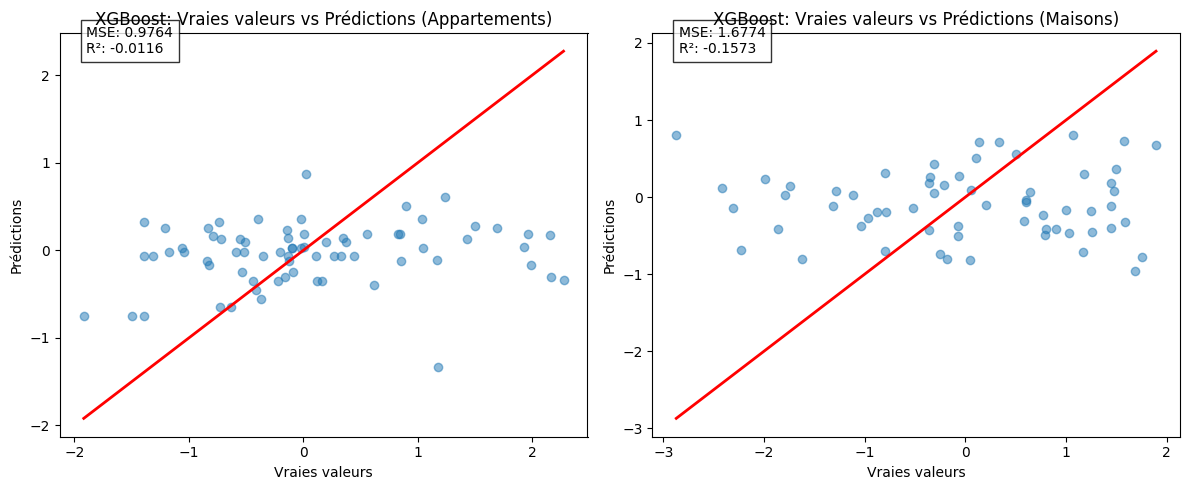

In [85]:
# XGBoost pour les appartements
print("XGBoost pour les appartements...")
xgb_model_appartements = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Entraînement
xgb_model_appartements.fit(
    X_train_appartements_scaled, 
    y_train_appartements_scaled.ravel(),
    eval_set=[(X_test_appartements_scaled, y_test_appartements_scaled)],
    verbose=False
)

# Prédictions
y_pred_xgb_appartements = xgb_model_appartements.predict(X_test_appartements_scaled)

# Métriques d'évaluation
mse_xgb = mean_squared_error(y_test_appartements_scaled, y_pred_xgb_appartements)
r2_xgb = r2_score(y_test_appartements_scaled, y_pred_xgb_appartements)

print("Résultats XGBoost pour les appartements:")
print(f"MSE: {mse_xgb:.4f}")
print(f"RMSE: {np.sqrt(mse_xgb):.4f}")
print(f"R²: {r2_xgb:.4f}")

# XGBoost pour les maisons
print("\nXGBoost pour les maisons...")
xgb_model_maisons = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Entraînement
xgb_model_maisons.fit(
    X_train_maisons_scaled, 
    y_train_maisons_scaled.ravel(),
    eval_set=[(X_test_maisons_scaled, y_test_maisons_scaled)],
    verbose=False
)

# Prédictions
y_pred_xgb_maisons = xgb_model_maisons.predict(X_test_maisons_scaled)

# Métriques d'évaluation
mse_xgb_maisons = mean_squared_error(y_test_maisons_scaled, y_pred_xgb_maisons)
r2_xgb_maisons = r2_score(y_test_maisons_scaled, y_pred_xgb_maisons)

print("Résultats XGBoost pour les maisons:")
print(f"MSE: {mse_xgb_maisons:.4f}")
print(f"RMSE: {np.sqrt(mse_xgb_maisons):.4f}") 
print(f"R²: {r2_xgb_maisons:.4f}")

# Visualisation des résultats
plt.figure(figsize=(12, 5))

# Appartements
plt.subplot(1, 2, 1)
plt.scatter(y_test_appartements_scaled, y_pred_xgb_appartements, alpha=0.5)
plt.plot([y_test_appartements_scaled.min(), y_test_appartements_scaled.max()],
         [y_test_appartements_scaled.min(), y_test_appartements_scaled.max()],
         'r', lw=2)
plt.xlabel('Vraies valeurs')
plt.ylabel('Prédictions')
plt.title('XGBoost: Vraies valeurs vs Prédictions (Appartements)')
plt.text(0.05, 0.95, f'MSE: {mse_xgb:.4f}\nR²: {r2_xgb:.4f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

# Maisons  
plt.subplot(1, 2, 2)
plt.scatter(y_test_maisons_scaled, y_pred_xgb_maisons, alpha=0.5)
plt.plot([y_test_maisons_scaled.min(), y_test_maisons_scaled.max()],
         [y_test_maisons_scaled.min(), y_test_maisons_scaled.max()],
         'r', lw=2)
plt.xlabel('Vraies valeurs') 
plt.ylabel('Prédictions')
plt.title('XGBoost: Vraies valeurs vs Prédictions (Maisons)')
plt.text(0.05, 0.95, f'MSE: {mse_xgb_maisons:.4f}\nR²: {r2_xgb_maisons:.4f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


**11. Évaluer les performances de tous les modèles**

- Utiliser la métrique **MSE** (`mean_squared_error`)
- Comparer les performances de tous les modèles testés
- Afficher un **tableau comparatif clair** pour :
    - les **appartements**
    - les **maisons**

Résultats pour les appartements:
                     Modèle     MSE      R²
0         Linear Regression  0.9718 -0.0068
1             Decision Tree  1.3130 -0.3603
2             Random Forest  1.0894 -0.1287
3                   XGBoost  0.9764 -0.0116
4  Decision Tree (optimisé)  0.9540  0.0117
5  Random Forest (optimisé)  0.8968  0.0709

Résultats pour les maisons:
                     Modèle     MSE      R²
0         Linear Regression  1.4874 -0.0262
1             Decision Tree  2.1814 -0.5050
2             Random Forest  1.6502 -0.1385
3                   XGBoost  1.6774 -0.1573
4  Decision Tree (optimisé)  1.5779 -0.0886
5  Random Forest (optimisé)  1.4876 -0.0264


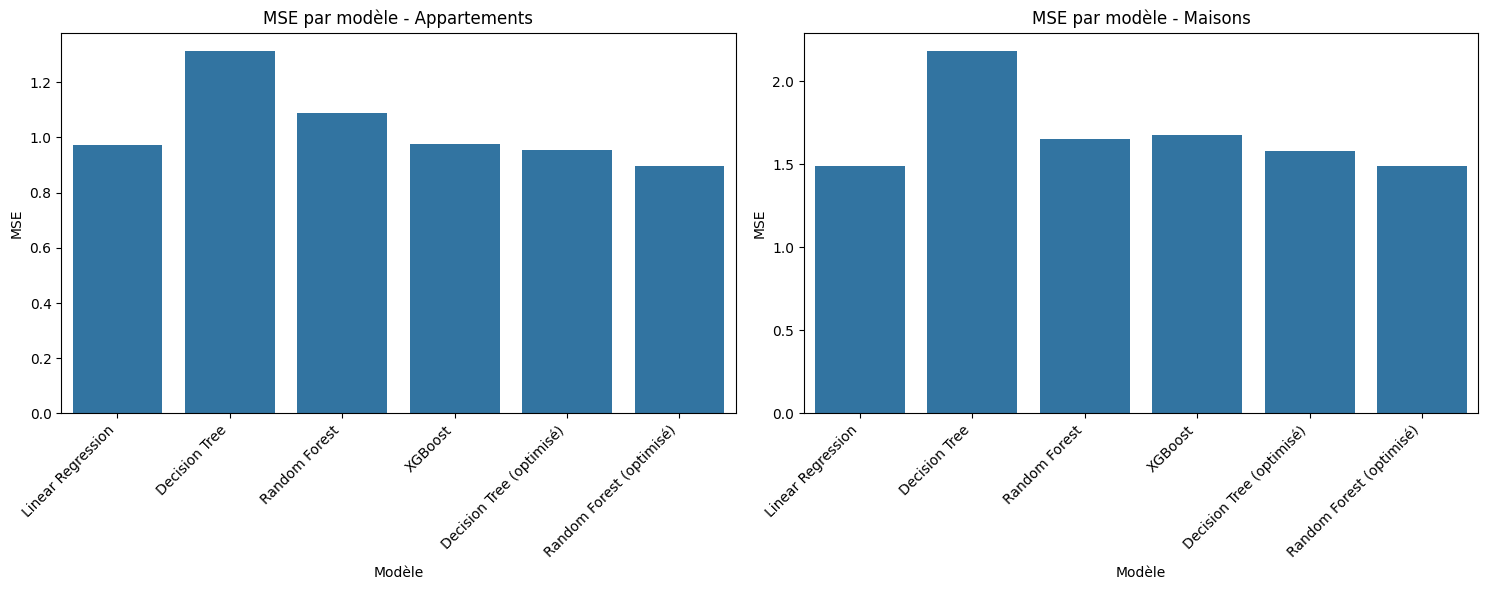

In [86]:
# Création des DataFrames pour comparer les performances
resultats_appartements = pd.DataFrame({
    'Modèle': ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 
               'Decision Tree (optimisé)', 'Random Forest (optimisé)'],
    'MSE': [mse, mse_dt, mse_rf, mse_xgb,
            mean_squared_error(y_test_appartements_scaled, y_pred_dt_app_opt),
            mean_squared_error(y_test_appartements_scaled, y_pred_rf_app_opt)],
    'R²': [r2_score(y_test_appartements_scaled, y_pred_appartements_scaled),
           r2_dt, r2_rf, r2_xgb,
           r2_score(y_test_appartements_scaled, y_pred_dt_app_opt),
           r2_score(y_test_appartements_scaled, y_pred_rf_app_opt)]
})

resultats_maisons = pd.DataFrame({
    'Modèle': ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost',
               'Decision Tree (optimisé)', 'Random Forest (optimisé)'],
    'MSE': [mse_maisons, mse_dt_maisons, mse_rf_maisons, mse_xgb_maisons,
            mean_squared_error(y_test_maisons_scaled, y_pred_dt_mai_opt),
            mean_squared_error(y_test_maisons_scaled, y_pred_rf_mai_opt)],
    'R²': [r2_score(y_test_maisons_scaled, y_pred_maisons_scaled),
           r2_dt_maisons, r2_rf_maisons, r2_xgb_maisons,
           r2_score(y_test_maisons_scaled, y_pred_dt_mai_opt),
           r2_score(y_test_maisons_scaled, y_pred_rf_mai_opt)]
})

# Affichage des résultats
print("Résultats pour les appartements:")
print("================================")
print(resultats_appartements.round(4))
print("\nRésultats pour les maisons:")
print("============================")
print(resultats_maisons.round(4))

# Visualisation graphique des performances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# MSE par modèle - Appartements
sns.barplot(x='Modèle', y='MSE', data=resultats_appartements, ax=ax1)
ax1.set_title('MSE par modèle - Appartements')
# Get the tick positions
ticks = ax1.get_xticks()
# Set new labels with rotation
ax1.set_xticks(ticks)
ax1.set_xticklabels(resultats_appartements['Modèle'], rotation=45, ha='right')

# MSE par modèle - Maisons
sns.barplot(x='Modèle', y='MSE', data=resultats_maisons, ax=ax2)
ax2.set_title('MSE par modèle - Maisons')
# Get the tick positions
ticks = ax2.get_xticks()
# Set new labels with rotation
ax2.set_xticks(ticks)
ax2.set_xticklabels(resultats_maisons['Modèle'], rotation=45, ha='right')

# Adjust layout to prevent label overlap
plt.tight_layout()
plt.show()

In [92]:
# Sauvegarde meilleur modèle appartements Lille
joblib.dump(rf_grid_appartements, "../models/model_appartements.pkl")
joblib.dump(scaler_X_appartements, "../models/scaler_x_appartements.pkl")
joblib.dump(scaler_y_appartements, "../models/scaler_y_appartements.pkl")

# Sauvegarde meilleur modèle maisons Lille
joblib.dump(model_maisons, "../models/model_maisons.pkl")
joblib.dump(scaler_X_maisons, "../models/scaler_x_maisons.pkl")
joblib.dump(scaler_y_maisons, "../models/scaler_y_maisons.pkl")

['../models/scaler_y_maisons.pkl']